# Poisson distributions

Fitting data to known distributions use is done using [Chi2Fit](https://hex.pm/packages/chi2fit).

This notebook is a companion to Appendix C of [5] (Second edition of the Kanban Maturity Model).

## Set-up

In [1]:
alias Chi2fit.Distribution, as: D
alias Chi2fit.Fit, as: F
alias Chi2fit.Matrix, as: M
alias Chi2fit.Utilities, as: U
alias Gnuplotlib, as: P
alias Exboost.Math

Exboost.Math

### Global parameters

In [2]:
# The size of the backlog, e.g. 50 backlog items
size = 50

# Number of iterations to use in the Monte Carlo
iterations = 1000

# Number of bootstraps to use
bootstraps = 100

# The size of bins for grouping the data
binsize = 4

# Number of probes to use in the chi2 fit
probes = 10_000

# The range of the parameter to look for a (global) minimum
initial = [{0.5,10}]

[{0.5, 10}]

In [3]:
Code.compiler_options(ignore_module_conflict: true)
defmodule Current do
  def random_fun1(model), do: fn _ -> Distribution.random(model) end
  def random_fun0(model), do: fn -> Distribution.random(model) end
  def ones_fun, do: fn -> 1 end
end
alias Current, as: C

Current

## Poisson: how bad is the mean?

See [5] page 399 figure C.16. We start with a sub-exponential Weibull distribution with kappa=0.8.

In [4]:
# Say, the rate is 23 items per 2 weeks (=10 working days)
rate = 23/10.0
period = 10.0
lambda = rate*period

23.0

In [5]:
f = D.model {"poisson",period}, pars: [rate]

#Poisson<"rate=2.3">

In [6]:
# See https://en.wikipedia.org/wiki/Poisson_distribution
IO.puts "Average\t\t= #{lambda}"
IO.puts "sqrt(Var)\t= #{:math.sqrt(lambda)}"
IO.puts "Median\t\t= #{:math.floor(lambda+1/3-0.02/lambda)}"
IO.puts "Mode\t\t= #{:math.ceil(lambda-1)}"

Average		= 23.0
sqrt(Var)	= 4.795831523312719
Median		= 23.0
Mode		= 22.0


:ok

Such a distribution typically looks like:

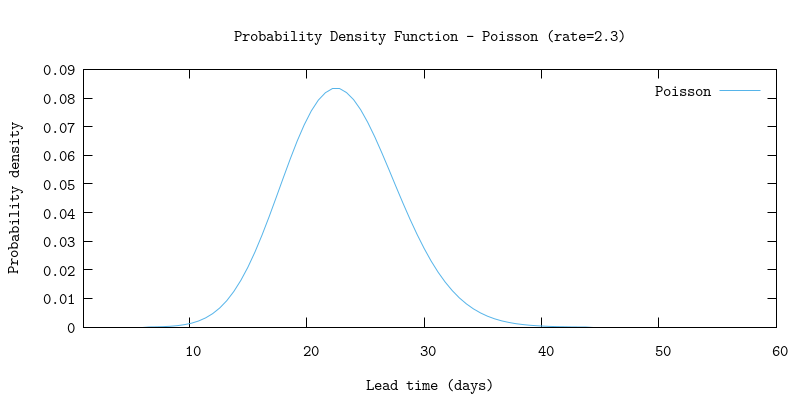

In [7]:
Gnuplot.plot([
    ~w(set terminal pngcairo size 800,400)a,
    ~w(set output)a,
    ~w|set xlabel "Lead\u00a0time\u00a0(days)"|a,
    ~w(set ylabel rotate by 90 "Probability\u00a0density")a,
    ~w(set title 'Probability\u00a0Density\u00a0Function\u00a0-\u00a0Poisson\u00a0(rate=#{rate}\)')a,
    ~w(set xrange [1:60])a,
    ~w(plot '-' u 1:2 w lines ls 3 title 'Poisson')a
  ],
  [ 1..100 |> Enum.map(& [&1/100*60,Distribution.pdf(f).(&1/100*60)]) ])
Gnuplotlib.capture() |> Base.encode64 |> IO.write
:"this is an inline image"

### Generate sample data
In this section we recreate the information and conclusions from Figure C.16 in [5].

We define a set of sample sizes ranging between 10 en 10000:

In [8]:
sample_sizes = [5,10,20,30,40,50,60,70,80,90,100,200,300,400,500,1_000,1_500,2_000,2_500,3_000,5_000,10_000]

[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 5000, 10000]

For each of the sizes above data samples are generated and calculate how the sample's mean deviates from the known mean calculated directly from the properties of the Weibull distribution.

In [9]:
avg_expected = lambda
result = sample_sizes |> Enum.map(fn sample_size ->
  {avg,sd} = U.mc(100, fn ->
        data = 1..sample_size |> Enum.map(C.random_fun1(f))
        mean = U.moment(data,1)
        abs(mean-avg_expected)/mean
    end)
  [sample_size,avg,sd]
end)
result |> U.as_table({"Sample size","Relative error to the mean","Error in the relative error"})
:"do not show this result in output"

Sample size|Relative error to the mean|Error in the relative error
-----------|--------------------------|---------------------------
5          |0.06490849896222019       |0.05008327921476777        
10         |0.05427653370825177       |0.03458512457313061        
20         |0.03412867731920129       |0.02800994266076435        
30         |0.027441819714943735      |0.021964406810916534       
40         |0.026547067771071395      |0.018003592145536953       
50         |0.024234063198393288      |0.01992022364913157        
60         |0.022993286231392122      |0.01648295665709258        
70         |0.020107306519018705      |0.016023706939983808       
80         |0.018709811725627957      |0.011951542254865135       
90         |0.016667637345733805      |0.012500604916705177       
100        |0.016649546773467347      |0.012326987849513912       
200        |0.010327017598102332      |0.0085767992666294         
300        |0.008256365576049711      |0.006188242881216591   

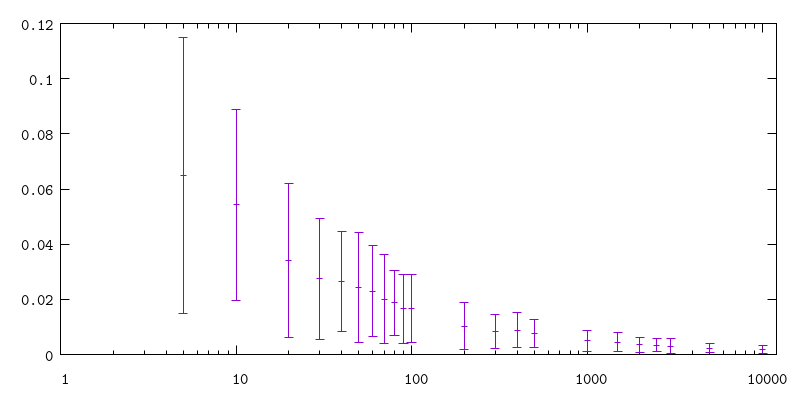

In [10]:
Gnuplot.plot([
    ~w(set terminal pngcairo size 800,400)a,
    ~w(set output)a,
    ~w(set xrange [1:12000])a,
    ~w(set logscale x 10)a,
    ~w(plot '-' u 1:2:3 w yerrorbars notitle)a
  ],
  [result])
Gnuplotlib.capture() |> Base.encode64 |> IO.write
:"this is an inline image"

In [12]:
sd_expected = :math.sqrt(lambda)
result = sample_sizes |> Enum.map(fn sample_size ->
  {avg,sd} = U.mc(100, fn ->
        data = 1..sample_size |> Enum.map(C.random_fun1(f))
        mean = U.moment(data,1)
        std = :math.sqrt U.momentc(data,2,mean)
        abs(std-sd_expected)/std
    end)
  [sample_size,avg,sd]
end)
result |> U.as_table({"Sample size","Relative error to the SD","Error in the relative error"})
:"do not show this result in output"

Sample size|Relative error to the SD|Error in the relative error
-----------|------------------------|---------------------------
5          |0.5347038554404296      |0.6792814116296072         
10         |0.20889762895955602     |0.2529071830125322         
20         |0.18001696057301936     |0.14572724888165217        
30         |0.1263195882387932      |0.12503600031284656        
40         |0.09794760377459615     |0.08878334989559641        
50         |0.08866548198647653     |0.06608929082197805        
60         |0.07668700225982286     |0.0577399200820529         
70         |0.06774421125860347     |0.05520357736447067        
80         |0.0678030181223226      |0.05520044334325127        
90         |0.06913331093124939     |0.051390723525292684       
100        |0.055071053454218796    |0.04948245671191612        
200        |0.037099786802232915    |0.026530672378050686       
300        |0.03204524041895837     |0.0233214553861428         
400        |0.02694878585

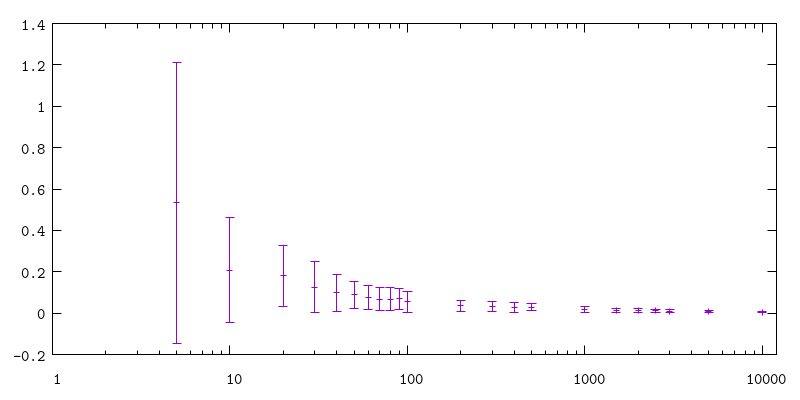

In [13]:
Gnuplot.plot([
    ~w(set terminal pngcairo size 800,400)a,
    ~w(set output)a,
    ~w(set xrange [1:12000])a,
    ~w(set logscale x 10)a,
    ~w(plot '-' u 1:2:3 w yerrorbars notitle)a
  ],
  [result])
Gnuplotlib.capture() |> Base.encode64 |> IO.write
:"this is an inline image"

The graph clearly shows a relative error from the mean less than 10% only when 100 or more data points are used. A relative error less than 5% is achieved for 500 or more data points.

Another thing to notice are the large error bars for small data samples. For a data sample of 10, the relative error from thee real mean can be anything between 0% and 80%!

### Forecast using a dataset

In [32]:
{avg_duration,sd_duration,all} = U.mc(iterations, U.forecast_duration(C.random_fun0(f),5000), collect_all?: true)
IO.puts "Average project duration\t= #{avg_duration}"
IO.puts "Relative error\t\t\t= #{sd_duration/avg_duration}"

Average project duration	= 217.753
Relative error			= 0.014268860687002083


:ok

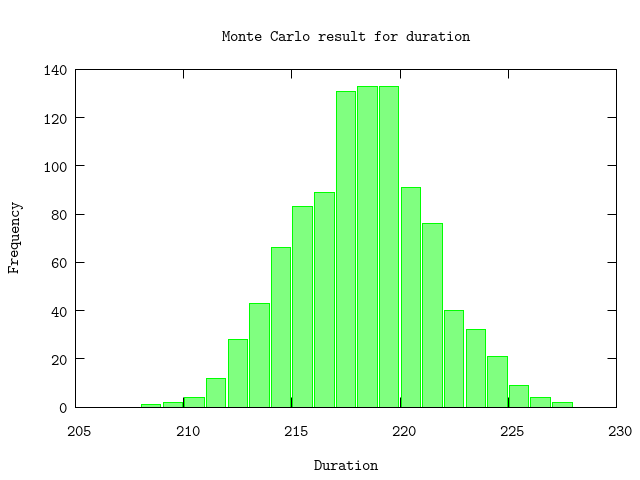

In [33]:
P.histogram(all,
    plottitle: "Monte Carlo result for duration",
    xlabel: "Duration",
    ylabel: "Frequency")
:"this is an inline image"

In [34]:
result = [20,100] |> Enum.map(fn sample_size ->
  {avg,sd} = U.mc(100, fn ->
        data = 1..sample_size |> Enum.map(C.random_fun1(f))
        {mean,_} = U.mc(100, U.forecast_duration(data,5000))
        abs(mean-avg_duration)/mean
    end)
  [sample_size,avg,sd]
end)
result |> U.as_table({"Sample size","Relative error to the mean","Error in the relative error"})
:"do not show this result in output"

Sample size|Relative error to the mean|Error in the relative error
-----------|--------------------------|---------------------------
20         |0.03619082817548668       |0.027946139304744974       
100        |0.017924781625045683      |0.012024914959431608       


### Forecast based on Poisson fit 

In [35]:
result = [20,100] |> Enum.map(fn sample_size ->
  {avg,sd} = U.mc(100, fn ->
        data = 1..sample_size |> Enum.map(C.random_fun1(f))
        hdata = U.to_bins data, {binsize,0}
        
        model = D.model {"poisson",period}
        
        options = [probes: probes, smoothing: false, model: :linear, saved?: true]
        result = {_,parameters,_,saved} = F.chi2probe hdata, initial, {Distribution.cdf(model), &F.nopenalties/2}, options
        
        options = [{:probes,saved}|options]
        result = {_,cov,parameters,_} = F.chi2fit hdata, {parameters, Distribution.cdf(model), &F.nopenalties/2}, 10, options
        
        fit = D.model {"poisson",period}, pars: parameters
        {duration,_} = U.mc(100, U.forecast_duration(C.random_fun0(fit),5000))
        abs(duration-avg_duration)/duration
    end)
  [sample_size,avg,sd]
end)
result |> U.as_table({"Sample size","Relative error to the mean","Error in the relative error"})
:"do not show this result in output"

Sample size|Relative error to the mean|Error in the relative error
-----------|--------------------------|---------------------------
20         |0.03886685247654866       |0.027977221907309096       
100        |0.01607900798284715       |0.01260392783015293        


The relative errors seen here are comparable to the errors shown in earlier sections.

## Example: forecast using empirical data (100 data points)

Using the histogram data for the throughput we perform a Monte Carlo simulation to get an estimation for the number of iterations needed to deplete the backlog. Since for a large enough number of samples results of a Monte Carlo simulation approximate the normal distribution. This provides a range for the uncertainty of the number of iterations. We express this as a probability using percentages.

In [36]:
data = 1..100 |> Enum.map(C.random_fun1(f))
{avg,_,all} = U.mc iterations, U.forecast_duration(data,5000), collect_all?: true
:"do not show this result in output"

The interpretation is that in 50% of the (simulation) runs all items have been completed with 20 iterations. And in 84% of the runs this took 22 iterations. We expect that in 16% of the times it will take more than 22 iterations to complete all items.

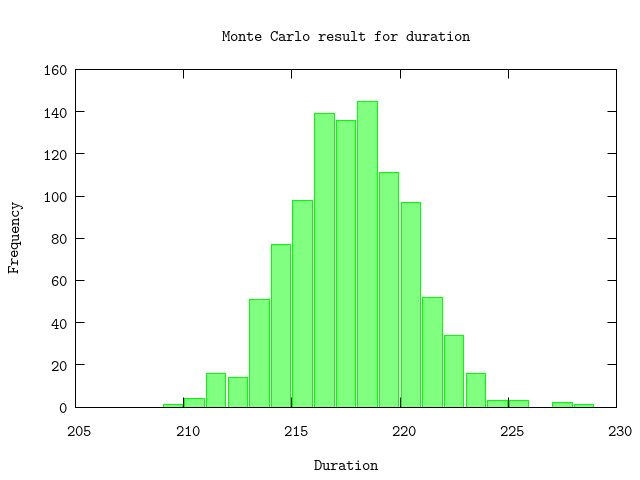

In [37]:
P.histogram(all,
    plottitle: "Monte Carlo result for duration",
    xlabel: "Duration",
    ylabel: "Frequency")
:"this is an inline image"

## References

[1] _Poisson distribution_, https://en.wikipedia.org/wiki/Poisson_distribution/<br>
[2] _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit<br>
[3] _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf<br>
[4] _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf<br>
[5] _Kanban Maturity Model_, David J Andersen & Teodora Bozheva, Edition 1.2